# Carbon nanotube with coulomb screening

Run this example with:

```bash
$ mpiexec -n $NP python run.py > out.txt
```

You may want to adjust the number of threads per rank in the `run.py`
script.

With the provided energy vector, this example ran at around 60s per
iteration on 128 CPU ranks. Total memory usage peaked around 200GB.

In [1]:
import glob
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from quatrex.core.quatrex_config import parse_config
from quatrex.post_processing.plot_ldos import get_averages, spectral_plot

simulation_dir = Path("/home/vetschn/src/python/quatrex/examples/w90/cnt-gw")

input_dir = simulation_dir / "inputs"
output_dir = simulation_dir / "outputs"

config = parse_config(simulation_dir / "config.toml")

## Convergence information

In [2]:
with open(simulation_dir / "out.txt") as f:
    out = f.readlines()

In [3]:
maximum_self_energy_updates = [
    float(line.split()[-1]) for line in out if "Maximum Self-Energy Update" in line
]
average_current_changes = [
    float(line.split()[-1]) for line in out if line.startswith("Average Current Change")
]
relative_average_current_changes = [
    float(line.split()[-1]) for line in out if "Relative Average Current Change" in line
]
current_differences = [
    float(line.split()[-1]) for line in out if "Current Difference" in line
]
relative_current_conservations = [
    float(line.split()[-1]) for line in out if "Relative Current Conservation" in line
]
right_conduction_band_edges = [
    float(line.split()[-1]) for line in out if "Updating conduction band" in line
]
left_conduction_band_edges = [
    float(line.split()[-2].strip(","))
    for line in out
    if "Updating conduction band" in line
]
iterations = [int(line.split()[-1]) for line in out if "Iteration" in line]

Text(0.5, 0, 'Iteration')

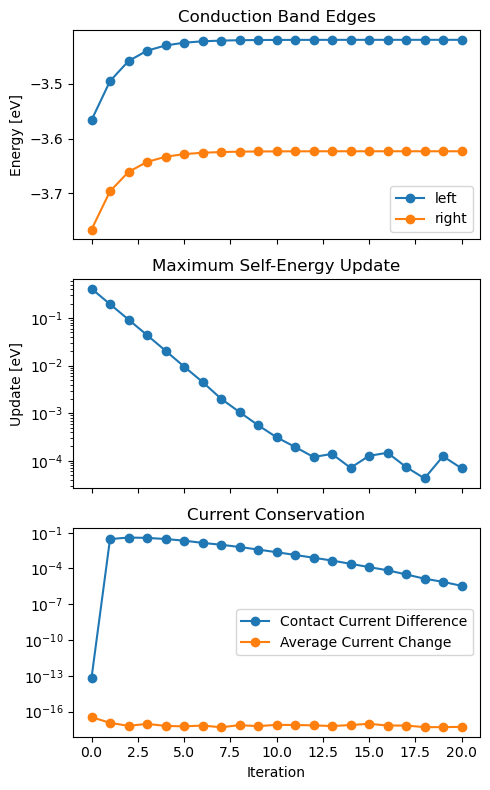

In [4]:
fig, (ax_band_edges, ax_self_energy, ax_current) = plt.subplots(
    3, 1, figsize=(5, 8), sharex=True, layout="tight"
)
ax_band_edges.plot(left_conduction_band_edges, marker="o", label="left")
ax_band_edges.plot(right_conduction_band_edges, marker="o", label="right")
ax_band_edges.legend()
ax_band_edges.set_ylabel("Energy [eV]")
ax_band_edges.set_title("Conduction Band Edges")

ax_self_energy.plot(maximum_self_energy_updates, marker="o")
ax_self_energy.set_yscale("log")
ax_self_energy.set_ylabel("Update [eV]")
ax_self_energy.set_title("Maximum Self-Energy Update")

ax_current.plot(
    np.abs(current_differences), label="Contact Current Difference", marker="o"
)
ax_current.plot(average_current_changes, label="Average Current Change", marker="o")
ax_current.set_yscale("log")
ax_current.set_title("Current Conservation")
ax_current.legend()

ax_current.set_xlabel("Iteration")

## Contact currents

In [5]:
left_files = glob.glob(str(output_dir / "i_left_*.npy"))
right_files = glob.glob(str(output_dir / "i_right_*.npy"))

left_currents = np.array([np.load(f) for f in left_files[:iterations[-1]]])
right_currents = np.array([np.load(f) for f in right_files[:iterations[-1]]])

Text(0, 0.5, 'Energy (eV)')

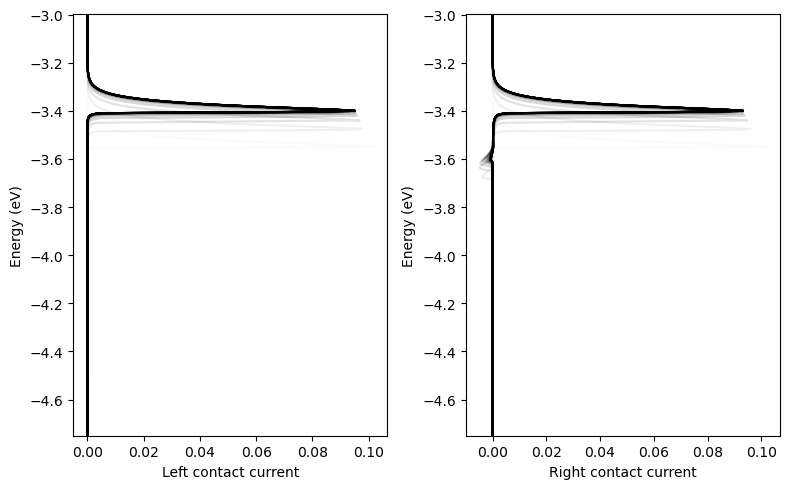

In [6]:
energies = np.load(input_dir / "electron_energies.npy")

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(8, 5), layout="tight")

num_iterations = len(left_currents)

for i, (left_current, right_current) in enumerate(zip(left_currents, right_currents)):
    ax_left.plot(
        -left_current.real, energies, "k", alpha=(i + 0.3) / (num_iterations + 0.3)
    )
    ax_right.plot(
        right_current.real, energies, "k", alpha=(i + 0.3) / (num_iterations + 0.3)
    )
    ax_left.set_ylim(-4.75, -3)
    ax_right.set_ylim(-4.75, -3)

ax_left.set_xlabel("Left contact current")
ax_right.set_xlabel("Right contact current")
ax_left.set_ylabel("Energy (eV)")
ax_right.set_ylabel("Energy (eV)")
# ax_left.set_xscale("log")
# ax_right.set_xscale("log")

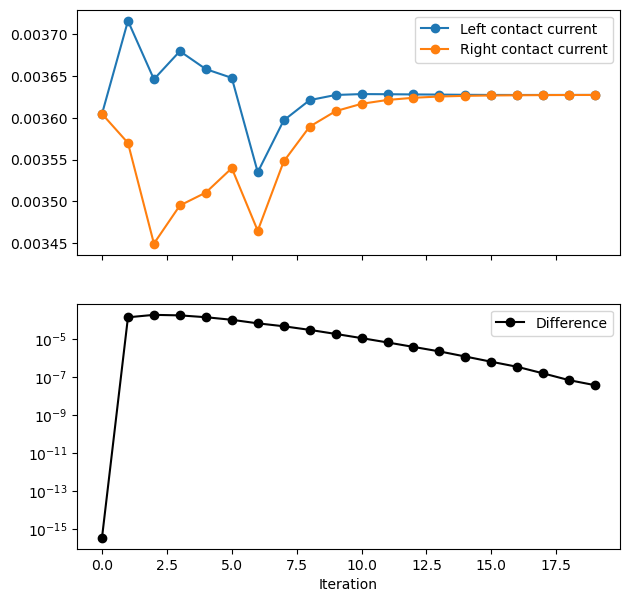

In [7]:
fig, (ax_currents, ax_diff) = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
dE = energies[1] - energies[0]
ax_currents.plot(
    -left_currents.sum(1).real * dE,
    label="Left contact current",
    marker="o",
)
ax_currents.plot(
    right_currents.sum(1).real * dE,
    label="Right contact current",
    marker="o",
)
diff = left_currents.sum(1).real * dE + right_currents.sum(1).real * dE
ax_diff.plot(np.abs(diff), label="Difference", color="k", marker="o")

ax_diff.legend()
ax_currents.legend()
ax_diff.set_xlabel("Iteration")
ax_diff.set_yscale("log")

## LDOS at the left contact

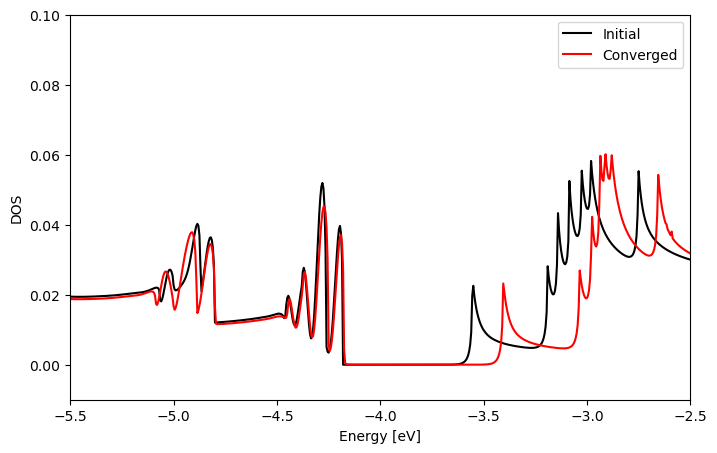

In [8]:
import glob

files = glob.glob(str(output_dir / "electron_ldos_*.npy"))
# DOS of first layer.
doss = np.array([np.load(f)[:, :32].mean(1) for f in files[:iterations[-1]]])
band_gaps = []
# Find peaks to determine band gaps.
for i in range(doss.shape[0]):
    peaks = find_peaks(doss[i], height=0.001)[0]
    peak_energies = energies[peaks]
    mask = (peak_energies - config.electron.left_fermi_level) < 0
    band_gaps.append(np.abs(peak_energies[mask].max() - peak_energies[~mask].min()))


fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(
    energies,
    doss[0],
    color="k",
    label="Initial",
)
ax.plot(
    energies,
    doss[-1],
    color="r",
    label="Converged",
)
ax.set_xlim(-5.5, -2.5)
ax.set_ylim(-0.01, 0.1)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("DOS")
ax.legend()

## Band gap over iterations

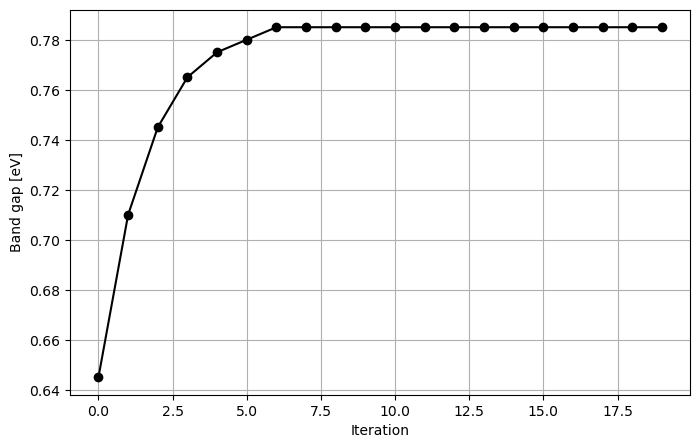

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(band_gaps, "o-", color="k")
ax.set_ylabel("Band gap [eV]")
ax.set_xlabel("Iteration")
ax.grid()

# Spectral plots for all computed quantities

In [10]:
ITERATION = 1  # Choose iteration to plot.

num_cells = len(np.load(input_dir / "block_sizes.npy"))

coulomb_energies = energies - energies[0]
electron_ldos = np.load(output_dir / f"electron_ldos_{ITERATION}.npy")
electron_density = np.load(output_dir / f"electron_density_{ITERATION}.npy")
hole_density = np.load(output_dir / f"hole_density_{ITERATION}.npy")
device_current = np.load(output_dir / f"device_current_{ITERATION}.npy")
meir_wingreen_current = np.load(output_dir / f"meir_wingreen_current_{ITERATION}.npy")

sigma_retarded = np.load(output_dir / f"sigma_retarded_density_{ITERATION}.npy")
sigma_lesser = np.load(output_dir / f"sigma_lesser_density_{ITERATION}.npy")
sigma_greater = np.load(output_dir / f"sigma_greater_density_{ITERATION}.npy")
p_retarded = np.load(output_dir / f"p_retarded_density_{ITERATION}.npy")
p_lesser = np.load(output_dir / f"p_lesser_density_{ITERATION}.npy")
p_greater = np.load(output_dir / f"p_greater_density_{ITERATION}.npy")
w_lesser = np.load(output_dir / f"w_lesser_density_{ITERATION}.npy")
w_greater = np.load(output_dir / f"w_greater_density_{ITERATION}.npy")
w_retarded = np.load(output_dir / f"w_retarded_density_{ITERATION}.npy")


left_fermi_level = config.electron.left_fermi_level
right_fermi_level = config.electron.right_fermi_level

(-5.5, -2.0)

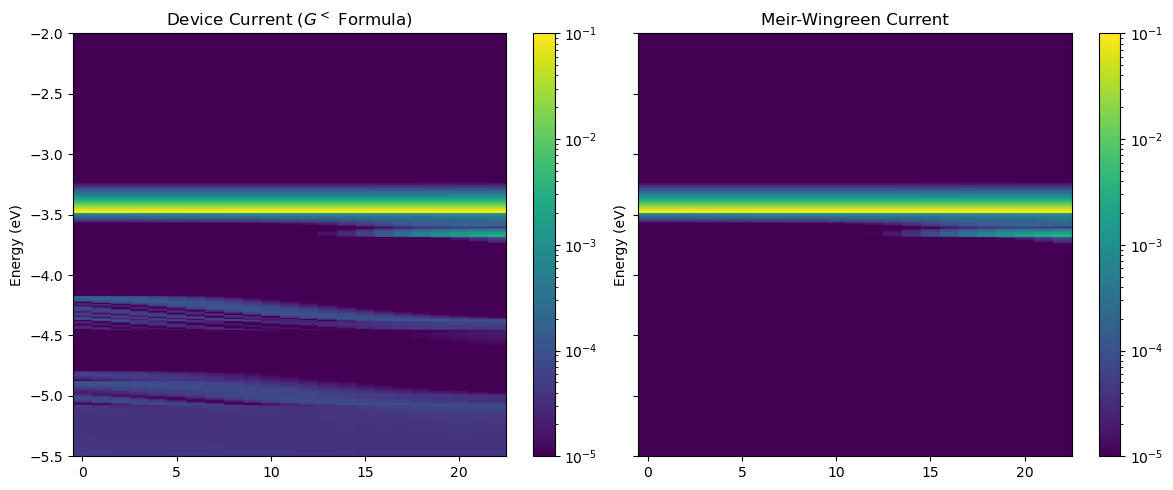

In [11]:
fig, (ax_current, ax_meir_wingreen) = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, layout="tight", sharey=True
)
spectral_plot(
    ax_current,
    np.abs(device_current.real),
    energies,
    cmap="viridis",
    norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-1),
)

ax_current.set_ylim(-5.5, -2.0)
ax_current.set_title("Device Current ($G^{<}$ Formula)")

spectral_plot(
    ax_meir_wingreen,
    np.abs(meir_wingreen_current.real),
    energies,
    cmap="viridis",
    norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-1),
)

ax_meir_wingreen.set_title("Meir-Wingreen Current")
ax_meir_wingreen.set_ylim(-5.5, -2.0)

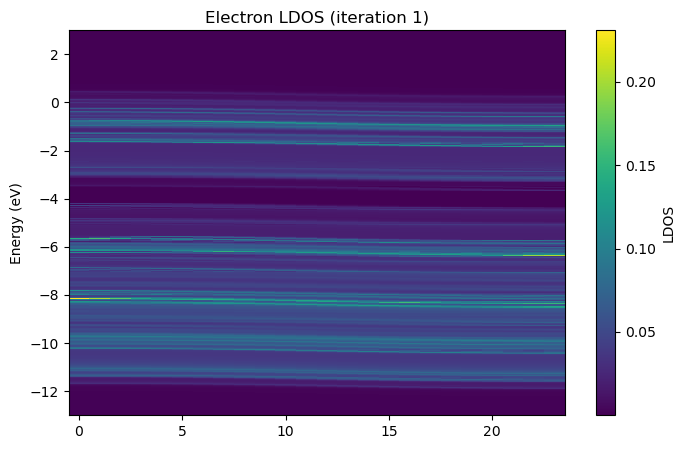

In [12]:
fig, ax_ldos = plt.subplots(figsize=(8, 5))

num_energies = len(energies)
average_ldos = get_averages(
    electron_ldos, num_energies, num_cells, method="cell-average"
)

average_ldos = average_ldos * (average_ldos > 0)

ax_ldos.set_title(f"Electron LDOS (iteration {ITERATION})")
spectral_plot(ax_ldos, average_ldos, energies, cmap="viridis", colorbar_label="LDOS")

# ax_ldos.set_ylim(-5.5, -2.0)

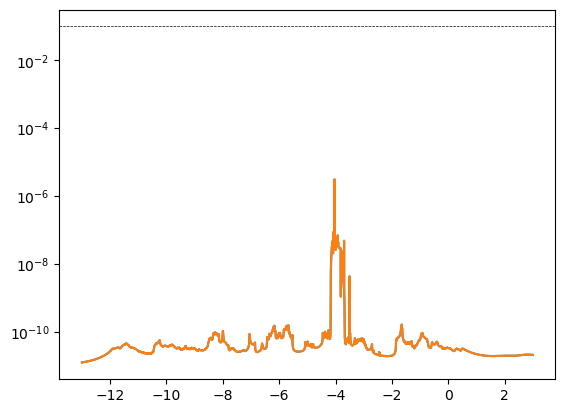

In [13]:
# This plots the DOS peak filtering criteria.

fig, ax = plt.subplots()

ne = electron_density.mean(1)
nh = hole_density.mean(1)
dos = electron_ldos.mean(1)

ax.plot(energies, np.abs(dos - (ne + nh) / 2) / (np.abs(dos) + 1e-6))
ax.plot(energies, np.abs(dos - (ne + nh) / 2) / (np.abs((ne + nh) / 2) + 1e-6))
ax.set_yscale("log")

ax.axhline(1e-1, color="black", lw=0.5, ls="--")

# ax.set_yscale('symlog', linthresh=1e-18)
# ax.set_xlim(-5.5, -2.0)

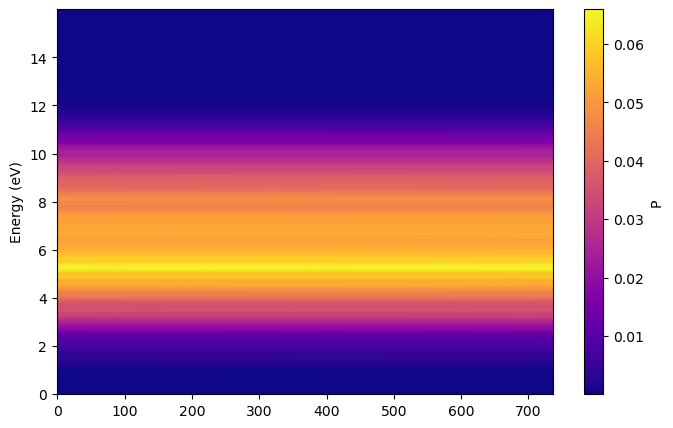

In [14]:
fig, ax_ldos = plt.subplots(figsize=(8, 5))

num_energies = len(energies)
average_ldos = get_averages(p_greater, num_energies, num_cells, method="rolling")

spectral_plot(
    ax_ldos, average_ldos, coulomb_energies, cmap="plasma", colorbar_label="P"
)

# ax_ldos.set_ylim(-5.5, -2.0)

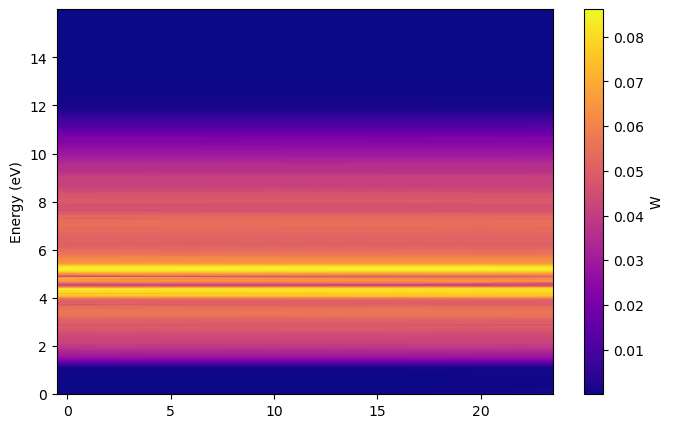

In [15]:
fig, ax_ldos = plt.subplots(figsize=(8, 5))

average_ldos = get_averages(w_greater, num_energies, num_cells, method="cell-average")

spectral_plot(
    ax_ldos, average_ldos, coulomb_energies, cmap="plasma", colorbar_label="W"
)

# ax_ldos.set_ylim(-5.5, -2.0)

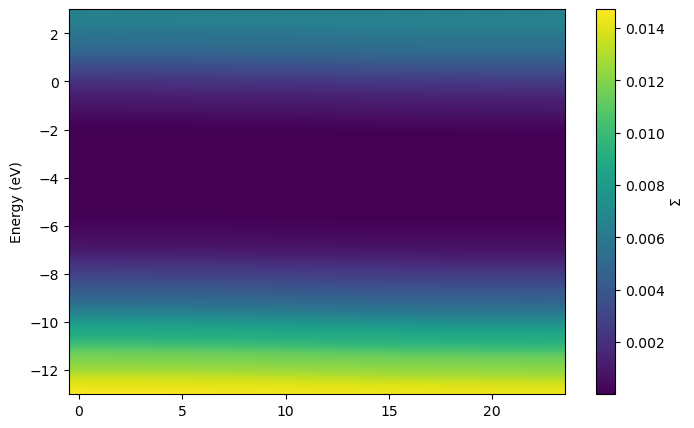

In [16]:
fig, ax_ldos = plt.subplots(figsize=(8, 5))

num_energies = len(energies)
average_ldos = get_averages(
    sigma_retarded, num_energies, num_cells, method="cell-average"
)

spectral_plot(
    ax_ldos, average_ldos, energies, cmap="viridis", colorbar_label="$\Sigma$"
)

# ax_ldos.set_ylim(-5.5, -2.0)